# Sea-ice function validation, pt. 2
This notebook runs through the validation process for the sea-ice statistics function. We will validate the function's calculations using the whole region of the Amundsen Sea Embayment (ASE). We'll first independently calculate the monthly sea-ice concentration averags, monthly sea-ice area sums, and monthly sea-ice area anomalies. Then, we will compare the independent calculations to the function output. 

In [1]:
# import modules
import numpy as np 
import matplotlib.pyplot as plt 
import numpy.ma as ma 
from pyproj import Transformer
import xarray as xr
import cmocean
import time 

In [2]:
# load data 
with np.load('ase_sic_12k.npz') as infile:
    sic = np.ma.MaskedArray(data=infile['data'], mask=infile['mask'])
    psx = infile['x']
    psy = infile['y']
    dates = infile['dates']

In [3]:
# set values 110, 120 to NaN 
data = np.copy(sic)
row, col, depth = data.shape

sic = np.ones((row, col))

for i in range(0, depth):
        day = data[:,:,i]
        day[day == 110] = 'NaN' # masks missing data
        day[day == 120] = 'NaN' # masks land 
        day = day 
        sic = np.dstack((sic, day))

sic = sic[:,:,1:] # remove filler ones from dataset 

In [4]:
# find the monthly averages of sic 
sic = np.copy(sic)
monthly_sic_avgs = [] 
monthly_avgs_labels = []

for j in range(min(dates[:,0]), max(dates[:,0])+1):
    for i in range(1,13):
        idx = np.argwhere((dates[:,0] == j) & (dates[:,1] == i))
        avg = np.nanmean(sic[:,:,idx])
        label = str(j) + '/' + str(i)
        monthly_sic_avgs = np.append(monthly_sic_avgs, avg)
        monthly_avgs_labels = np.append(monthly_avgs_labels, label)

<ipython-input-4-14a8ed3cfe62>:9: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(sic[:,:,idx])


In [5]:
# derive sea-ice area (sia) fron sic 
sia = np.copy(sic) 
with np.nditer(sia, op_flags=['readwrite']) as k:
    for x in k:
        x[...] = (x/100) * 12.5**2
        
row, col, depth = sia.shape 

<ipython-input-6-c9ff6aad73ff>:12: RuntimeWarning: invalid value encountered in double_scalars
  avg = total / days


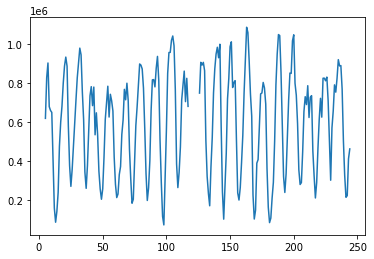

In [6]:
# find monthly average sia

monthly_sia_avgs = [] 
months = [] # create list of months 
years = [] # create list of years 

for j in range(min(dates[:,0]), max(dates[:,0])+1):
    for i in range(1,13):
        idx = np.argwhere((dates[:,0] == j) & (dates[:,1] == i))
        total = np.nansum(np.nansum(sia[:,:,idx]))
        days = len(idx)
        avg = total / days 
        monthly_sia_avgs = np.append(monthly_sia_avgs, avg)
        month = int(i)
        months = np.append(months, month)
        year = int(j) 
        years = np.append(years, year)

mdates = np.vstack((years, months)) # create dates array of just months, not daily like previous array         

plt.plot(monthly_sia_avgs)

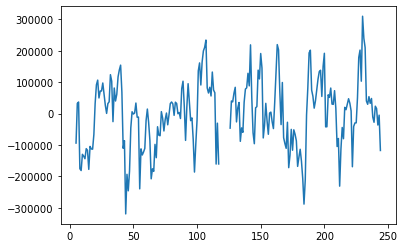

In [7]:
# find series avg of monthly sia sums 

series_avgs = [0]

for i in range(1,13):
    idx = np.argwhere((mdates[1] == i))
    avg = np.nanmean(monthly_sia_avgs[idx])
    series_avgs = np.append(series_avgs, avg)
    
# find monthly anomaly of sia 

monthly_anoms = [] 
ymin = min(mdates[0], key=lambda x:float(x))
ymax = max(mdates[0], key=lambda x:float(x))

for j in range(int(ymin), int(ymax)+1):
    for i in range(1,13):
        idx = np.argwhere((mdates[0] == j) & (mdates[1] == i))
        anom = monthly_sia_avgs[idx] - series_avgs[i]
        monthly_anoms = np.append(monthly_anoms, anom)

plt.plot(monthly_anoms)

Now we'll use the function and input the PSXY coordinates for the whole of the ASE. 

In [8]:
# Load sic data 
with np.load('ase_sic_12k.npz') as infile:
    sic = np.ma.MaskedArray(data=infile['data'], mask=infile['mask'])
    psx = infile['x']
    psy = infile['y']
    dates = infile['dates']

# Load BedMachine Antarctica V2 and extract ice masks

# Path to the BedMachine netCDF file, change this to whereever you save the BedMachine file
bmpath = r'C:\Users\Keyleigh_Walliack\Documents\Amundsen_sea\Sea ice\BedMachineAntarctica_2020-07-15_v02.nc'

# Open the netCDF file
xr_ds = xr.open_dataset(bmpath)

mask = xr_ds.mask.squeeze()

# Convert ocean mask from 0 to nan
mask.data = mask.data.astype('float')
mask.data[mask.data == 0] = 'nan'
    
# Downsample and extract mask for ASE from BedMachine

# Find and round the extent of the ASE sic data to the nearest 1 km
xmin = np.floor(min(psx)/1000)*1000
xmax = np.round(max(psx)/1000)*1000
ymin = np.floor(min(psy)/1000)*1000
ymax = np.round(max(psy)/1000)*1000

# Interpolation interval, meters
dxy = 2500

# Resolution of the sic data, meters
dxy_sic = 12500

# x and y coordinates for interpolating the mask
xx = np.arange(xmin-dxy_sic/2, xmax+dxy_sic/2, dxy)
yy = np.arange(ymin-dxy_sic/2, ymax+dxy_sic/2, dxy)

# Interpolate the mask
mask_int = mask.interp(coords={'x': xx,'y': yy}, method = 'linear')

In [9]:
# define sea-ice function 
def get_sea_ice_stats(x1,y1,x2,y2, sic_arr, dates_arr, psx_arr, psy_arr, day_plot):
    """
    Input PSXY coordinates, in km, of top left and bottom right corners of area of interest. Coordinates must be within the 
    ASE. Input sic, dates, and PSXY arrays and choice of day to plot. Outputs one-day plot of interest area over regional plot
    of the ASE and plots of the area's monthly average sea-ice concentration, monthly average sea-ice area, and monthly sea-ice
    area anomaly.
    """ 
    start = time.time()
    
    ## Find index of PSXY coordinates 
    arr_x = psx_arr
    arr_y = psy_arr
    
    xa = x1 * 1000
    diff_xa = np.absolute(arr_x - xa)
    idx_x1 = diff_xa.argmin()
    
    ya = y1 * 1000
    diff_ya = np.absolute(arr_y - ya)
    idx_y1 = diff_ya.argmin()
     
    xb = x2 * 1000 
    diff_xb = np.absolute(arr_x - xb)
    idx_x2 = diff_xb.argmin()
    
    yb = y2 * 1000
    diff_yb = np.absolute(arr_y - yb)
    idx_y2 = diff_yb.argmin()
    
    xs = [idx_x1, idx_x2]
    ys = [idx_y1, idx_y2]
    
    area_sic = sic_arr[min(ys):max(ys)+1, min(xs):max(xs)+1, :]
    row, col, depth = area_sic.shape # depth = number of days 
    
    # get psxy for area of interest for plotting 
    area_x = psx_arr[min(xs):max(xs)+1]
    area_y = psy_arr[min(ys):max(ys)+1]
     
    ## Output array 1 calculation 
    # find monthly averages of sea-ice concentration
    
    monthly_sic_avgs = [] # output array 1 
    month_labels = []
    
    for j in range(min(dates_arr[:,0]), max(dates_arr[:,0])+1):
                   for i in range(1,13):
                       idx = np.argwhere((dates_arr[:,0] == j) & (dates_arr[:,1] == i))
                       avg = np.nanmean(area_sic[:,:,idx])
                       label = str(j) + '/' + str(i)
                       monthly_sic_avgs = np.append(monthly_sic_avgs,avg)
                       month_labels = np.append(month_labels, label)
    
    # get sea-ice area from sea-ice concentration
    area_sia = np.empty((row, col, depth))
    area_sia[:] = np.nan

    for i in range(depth):
        area_sia[:,:,i] = area_sic[:,:,i]/100 * 12.5**2

    ## Output array 2 calculation 
    # find monthly average sea-ice area  
    
    monthly_sia_avgs = [] # output array 2
    
    months = [] # create list of months
    years = [] # create list of years 
    
    for j in range(min(dates_arr[:,0]), max(dates_arr[:,0])+1):
        for i in range(1,13):
            idx = np.argwhere((dates_arr[:,0] == j) & (dates_arr[:,1] == i))
            total = np.nansum(np.nansum(area_sia[:,:,idx]))
            days = len(idx)
            avg = total / days
            monthly_sia_avgs = np.append(monthly_sia_avgs, avg)
            year = int(j)
            years = np.append(years, year)
            month = int(i)
            months = np.append(months, month)
    
    dates_monthly = np.vstack((years,months)) # creates new dates array that is just months, not daily. output array 4  
    
    ## Output array 3 calculation 
    # find series average of monthly sums for each month
    
    series_avgs = [0] #set first element be zero to simplify indexing for future anomaly calculation
    
    for i in range(1,13):
        idx = np.argwhere((dates_monthly[1] == i))
        avg = np.nanmean(monthly_sia_avgs[idx])
        series_avgs = np.append(series_avgs, avg)

    # calculate monthly total sia anomaly 
    monthly_sia_anoms = [] # output array 3 
    
    year_min = min(dates_monthly[0,:], key=lambda x:float(x))
    year_max = max(dates_monthly[0,:], key=lambda x:float(x))
    
    for j in range(int(year_min), int(year_max)+1):
        for i in range(1,13):
            idx = np.argwhere((dates_monthly[0] == j) & (dates_monthly[1] == i))
            anom = monthly_sia_avgs[idx] - series_avgs[i]
            monthly_sia_anoms = np.append(monthly_sia_anoms, anom)
    
    ## Plot interest area and its monthly avgs (sic), totals (sia), and anomalies (sia)
    
    # index of a day to plot
    area_plot = area_sic[:, :, day_plot]
    ase_plot = sic_arr[:, :, day_plot]
    
    # rectangle for area of interest 
    width = (psx_arr[idx_x2]/1000) - (psx_arr[idx_x1]/1000)
    height = (psy_arr[idx_y1]/1000) - (psy_arr[idx_y2]/1000)
    
    # plot one day
    plt.figure(dpi = 200)
    plt.pcolormesh(psx_arr/1000, psy_arr/1000, ase_plot, cmap=cmocean.cm.ice, shading='nearest', vmin=0, vmax=100)
    cbar = plt.colorbar()
    cbar.set_label('Sea-ice concentration (%)')
    plt.pcolormesh(mask_int.x/1000, mask_int.y/1000, mask_int.data, cmap=cmocean.cm.gray, shading='nearest', vmin=1, vmax=4)
    plt.xlabel('PSX (km)')
    plt.ylabel('PSY (km)')
    plt.gca().add_patch(Rectangle((psx_arr[idx_x1]/1000,psy_arr[idx_y2]/1000), width, height, edgecolor='red', fill=False))
    titletxt = str(dates[day_plot,0]) + '/' + str(dates[day_plot,1]) + '/' + str(dates[day_plot,2])
    plt.title(titletxt)
    plt.axis('equal')
    plt.show()
                                    
    # plot avgs and anomalies 
    length = len(monthly_sic_avgs)
    x = month_labels[0:length+1:6] # labels for x-axis for avg concentration plot
    zeros = np.zeros(length) # for zero slope in anomaly plot
    
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,20))
    fig.tight_layout(h_pad = 5)
    ax0.plot(month_labels,monthly_sic_avgs, 'darkorange')
    ax0.set_xticks(np.arange(1,length+1,6))
    ax0.set_xticklabels(x,rotation=60)
    ax0.set(title=r'Monthly average sea-ice concentration', ylabel=r'SIC (%)')
    
    ax1.plot(month_labels, monthly_sia_avgs, 'seagreen')
    ax1.set_xticks(np.arange(1,length+1,6))
    ax1.set_xticklabels(x,rotation=60)
    ax1.set(title=r'Monthly average sea-ice area', ylabel=r'SIA ($km^2$)')
    
    ax2.plot(month_labels, monthly_sia_anoms, 'darkviolet')
    ax2.plot(month_labels, zeros, 'k--')
    ax2.set_ybound(upper= np.nanmax(abs(monthly_sia_anoms))+1000, lower=-np.nanmax(abs(monthly_sia_anoms))-1000)
    ax2.set_xticks(np.arange(1, length+1,6))
    ax2.set_xticklabels(x, rotation=60)
    ax2.set(title=r'Monthly sea-ice area anomaly', ylabel=r'SIA ($km^2$)')
    plt.show()
    
    end = time.time()
    print('Elapsed time:', np.round((end-start)*1e6)/1e6, 'seconds.')
    
    return monthly_sic_avgs, monthly_sia_avgs, monthly_sia_anoms, dates_monthly, month_labels
    # optional: save arrays as an npz file
   # np.savez_compressed('interest_area_data.npz', monthly_sic_avgs = monthly_sic_avgs, monthly_sia_avgs = monthly_sia_avgs, 
    #                    monthly_sia_anomaly = monthly_sia_anoms, dates_monthly = dates_monthly)

The indices for the area of interest are 0 : 120 , 0 : 77 .


C:\Users\Keyleigh_Walliack\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:217: UserWarning: Warning: converting a masked element to nan.
  return a.dtype.type(a / b)
<ipython-input-9-b2aed339be52>:90: RuntimeWarning: invalid value encountered in double_scalars
  avg = total / days


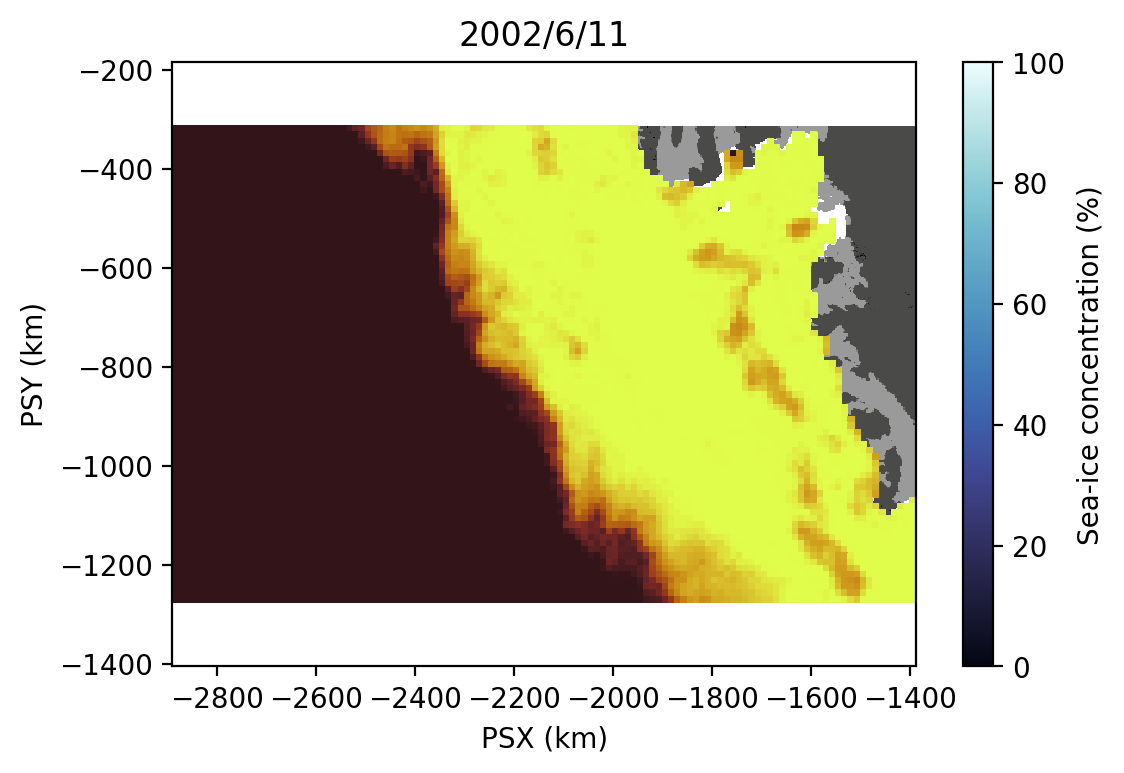

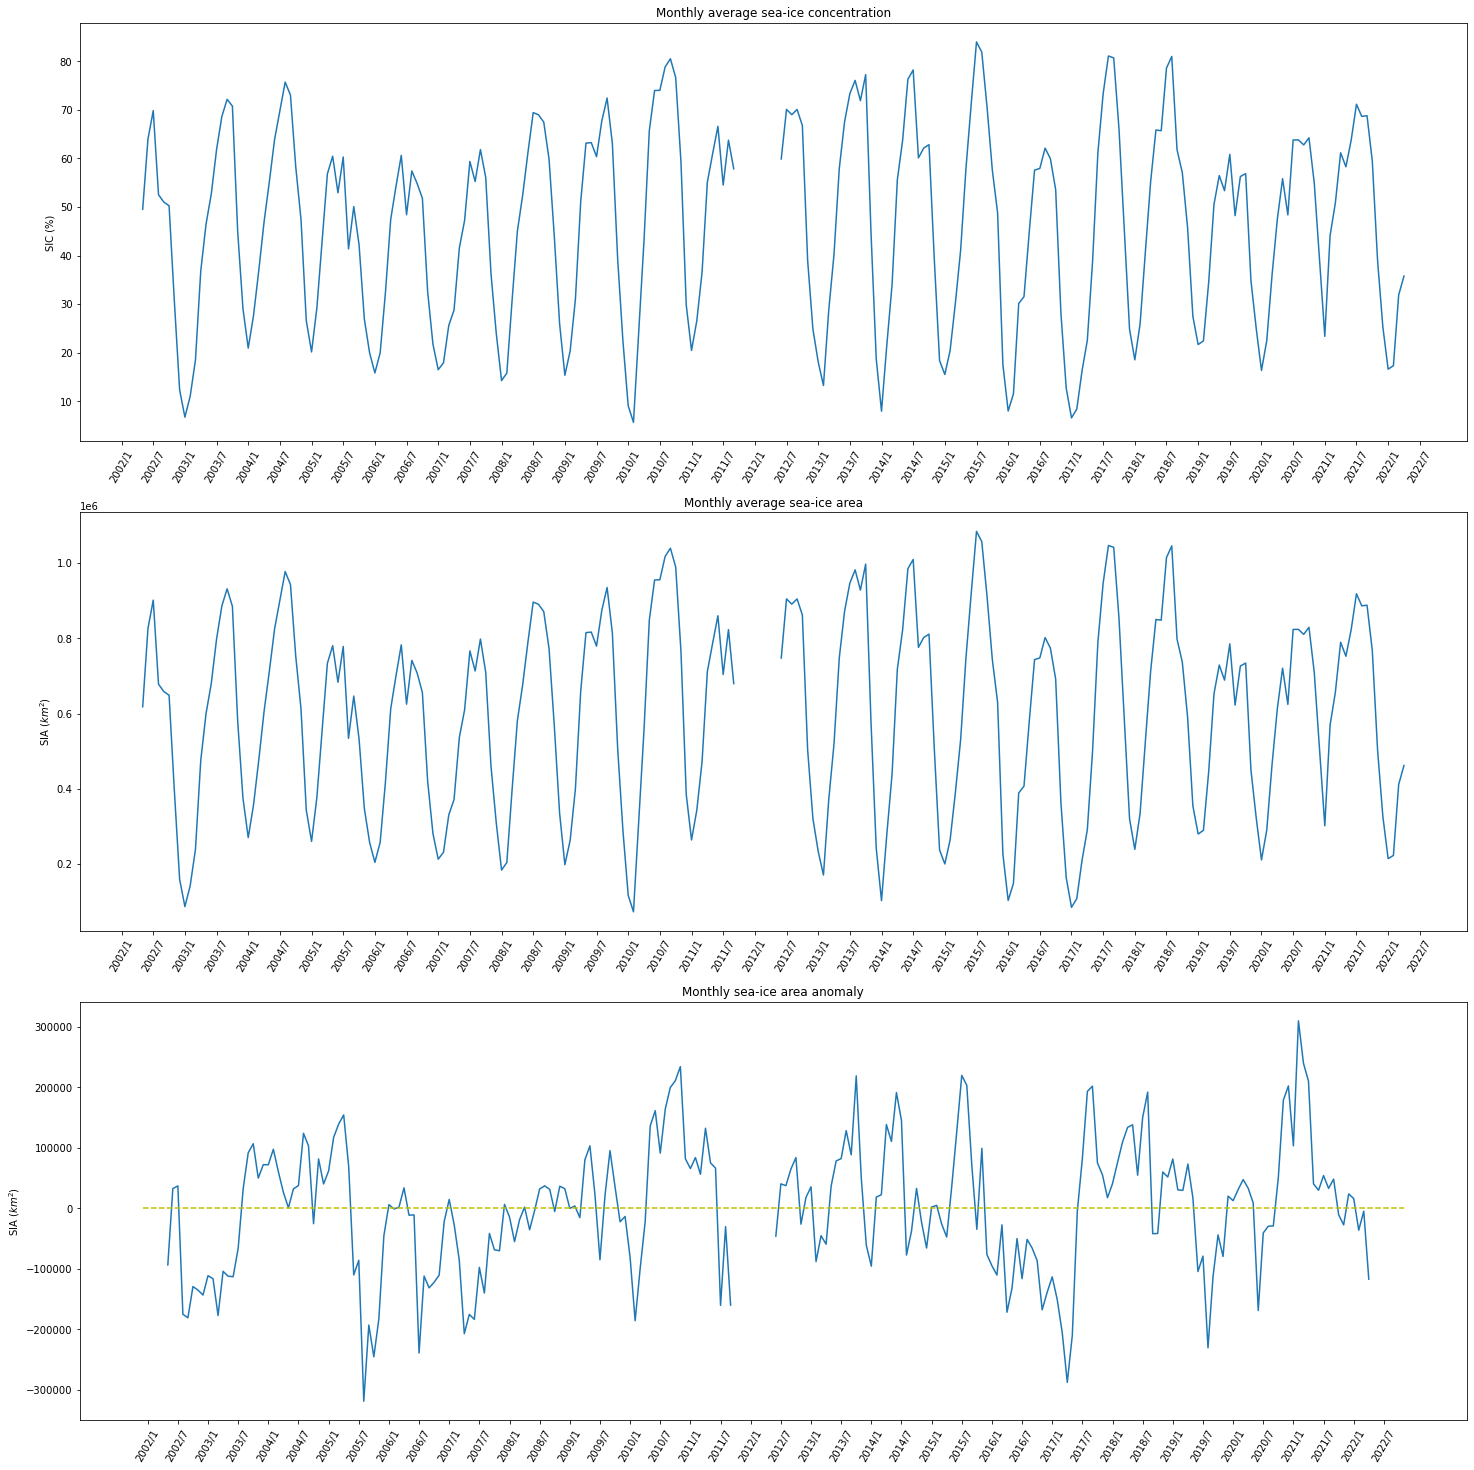

In [10]:
a,b,c,d,e = get_sea_ice_stats(-2880, -300, -1345, -1375,10, sic, dates, psx, psy)

Now let's plot the output of the function with the independently calculated averages, sums, and anomalies. 

In [11]:
monthly_sic_avgs_func = a
monthly_sia_avgs_func = b
monthly_anoms_func = c

Visually, the function output and independent calculations look the same. Let's plot the difference to ensure. 

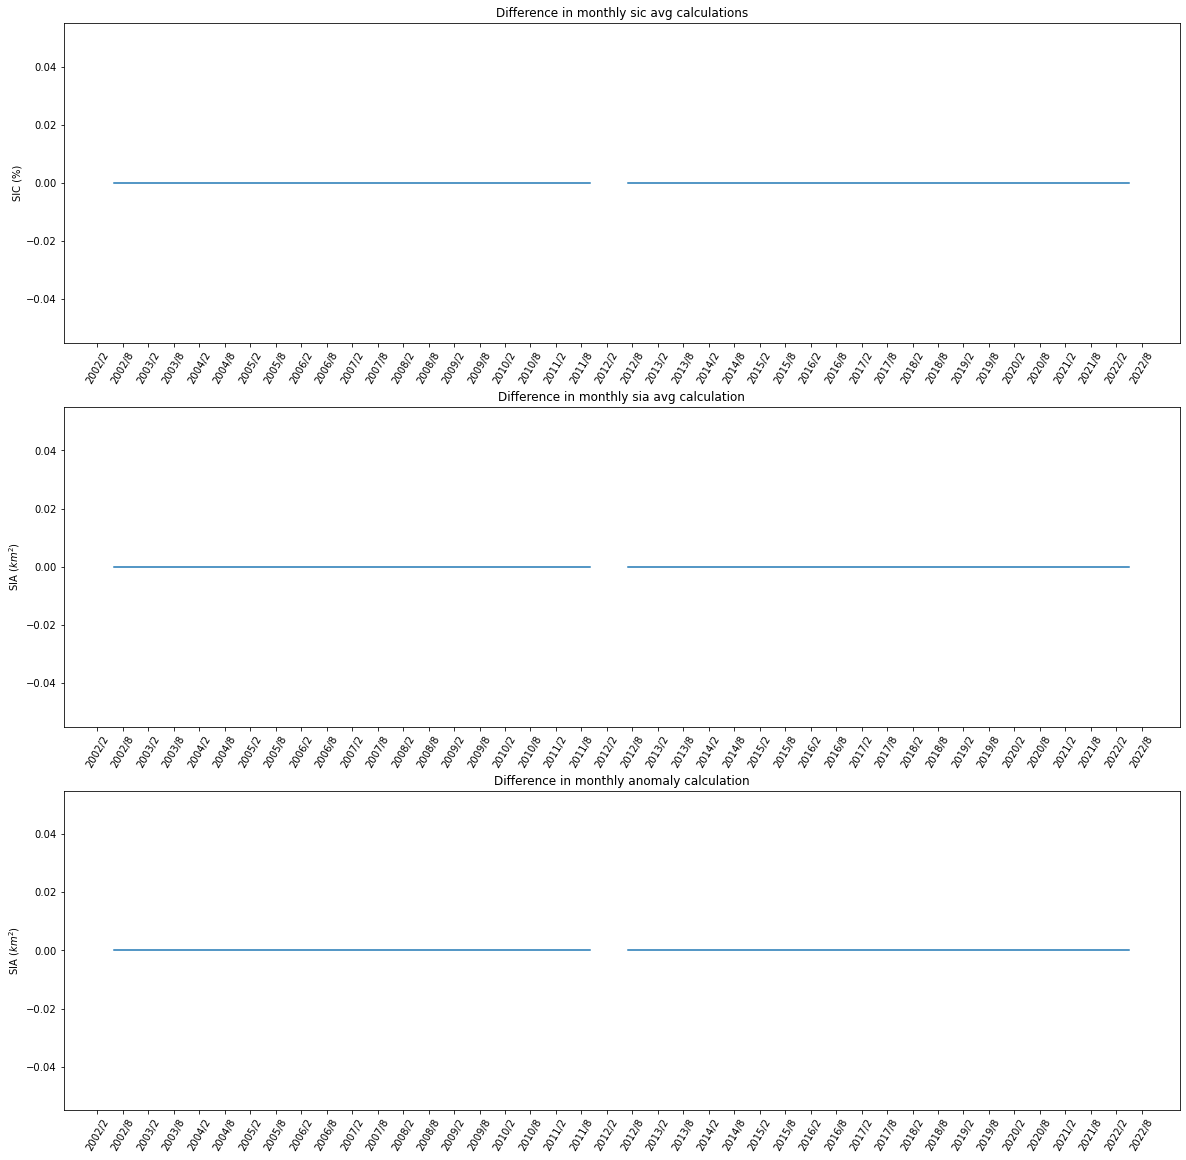

In [12]:
# find differences  
monthly_sic_avg_diff = np.subtract(monthly_sic_avgs, monthly_sic_avgs_func)
monthly_sia_avg_diff = np.subtract(monthly_sia_avgs, monthly_sia_avgs_func)
monthly_anom_diff = np.subtract(monthly_anoms, monthly_anoms_func)

# set up x-axis time label
monthly_labels = monthly_avgs_labels
length = len(monthly_labels)
time = monthly_labels[1:length+1:6]

# plot differences
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,20))
ax0.plot(monthly_labels, monthly_sic_avg_diff)
ax0.set_xticks(np.arange(1,length+1,6))
ax0.set_xticklabels(time, rotation=60)
ax0.set(title=r'Difference in monthly sic avg calculations', ylabel=r'SIC (%)')
ax1.plot(monthly_labels, monthly_sia_avg_diff)
ax1.set_xticks(np.arange(1,length+1,6))
ax1.set_xticklabels(time, rotation=60)
ax1.set(title=r'Difference in monthly sia avg calculation', ylabel=r'SIA ($km^2$)')
ax2.plot(monthly_labels, monthly_anom_diff)
ax2.set_xticks(np.arange(1,length+1,6))
ax2.set_xticklabels(time,rotation=60)
ax2.set(title=r'Difference in monthly anomaly calculation', ylabel=r'SIA ($km^2$)')
plt.show()